#### Rozwiązanie zad 2

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
def draw_image(matrix, m=256, image_size=512, d=2, filename="", popout=False, save_gif=False):
    image = Image.new(mode="RGB", color=(0, 0, 0), size=(image_size, image_size))
    for i in range(m):
        for j in range(m):
            color = (0, 0, 0) if matrix[i, j] else (255, 255, 255)
            for k in range(i*d, i*d + d):
                for l in range(j*d, j*d + d):
                    image.putpixel((k, l), color)

    if popout:
        image.show()
    if filename:
        image.save(f"binary_pictures/{filename}")
    if save_gif:
        return image
    display(image)


def plot_energy(energy):
    plt.plot([i for i in range(len(energy))], energy)
    plt.title("Energy levels")
    plt.show()


def plot_temperature(temperature):
    plt.plot([i for i in range(len(temperature))], temperature)
    plt.title("Temperature function")
    plt.show()

In [3]:
def prepare_image(matrix, m, density):
    for i in range(m):
        for j in range(m):
            matrix[i, j] = 1 if np.random.rand() < density else 0

### Generowanie sąsiedztwa

Przejście ze stanu do stanu w każdym przypadku oznacza zamienienie dwóch różnych pikseli miejscami. Dwa kolory można zamienić w danej iteracji jeśli ze sobą
sąsiadują. Definiuje łącznie 6 rodzajów sąsiedztwa:



In [4]:
'''
1. pole może zamienić się z polem bezpośrednio pod nim lub na prawo od niego,
        X X
        X
'''

def neighbor1(matrix):
    m = matrix.shape[0]
    x, y = np.random.randint(1, m - 2), np.random.randint(1, m - 2)
    x_d, y_d = 0, 0
    if np.random.randint(0, 2):
        x_d = 1
    else:
        y_d = 1
    if matrix[x, y] != matrix[x + x_d, y+y_d]:
        return (x, y), (x + x_d, y + y_d)
    return None

'''
2. pole może zamienić się z polem bezpośrednio nad nim, pod nim, na prawo lub lewo
    X
  X X X
    X
'''

def neighbor2(matrix):
    m = matrix.shape[0]
    x, y = np.random.randint(1, m - 2), np.random.randint(1, m - 2)
    x_d, y_d = 0, 0
    if np.random.randint(0, 2):
        x_d = 1 if np.random.randint(0, 2) else -1
    else:
        y_d = 1 if np.random.randint(0, 2) else -1
    if matrix[x, y] != matrix[x + x_d, y+y_d]:
        return (x, y), (x + x_d, y + y_d)
    return None

'''
3. Tak samo jak w 2 tylko dochodzą pola "na rogach"
    X X X
    X X X
    X X X
'''

def neighbor3(matrix):
    m = matrix.shape[0]
    x, y = np.random.randint(1, m - 2), np.random.randint(1, m - 2)
    x_d, y_d = np.random.randint(-1, 2), np.random.randint(-1, 2)
    if matrix[x, y] != matrix[x + x_d, y+y_d]:
        return (x, y), (x + x_d, y + y_d)
    return None

'''
4. Tylko pola na "na rogach"
    X   X
      X
    X   X
'''

def neighbor4(matrix):
    m = matrix.shape[0]
    t = [-1, 1]
    x, y = np.random.randint(1, m - 2), np.random.randint(1, m - 2)
    x_d, y_d = t[np.random.randint(0, 2)], t[np.random.randint(0, 2)]
    if matrix[x, y] != matrix[x + x_d, y+y_d]:
        return (x, y), (x + x_d, y + y_d)
    return None
'''
5. Tylko góra i dół
     X
     X
     X
'''

def neighbor5(matrix):
    m = matrix.shape[0]
    t = [-1, 1]
    x, y = np.random.randint(1, m - 2), np.random.randint(1, m - 2)
    x_d, y_d = t[np.random.randint(0, 2)], 0
    if matrix[x, y] != matrix[x + x_d, y+y_d]:
        return (x, y), (x + x_d, y + y_d)
    return None

'''
6. Tylko skos
        X
     X
  X
'''

def neighbor6(matrix):
    m = matrix.shape[0]
    x, y = np.random.randint(1, m - 2), np.random.randint(1, m - 2)
    x_d, y_d = (1, -1) if np.random.randint(0, 2) else (-1, 1)
    if matrix[x, y] != matrix[x + x_d, y+y_d]:
        return (x, y), (x + x_d, y + y_d)
    return None

### Funkcje energii

Energia całegu układu jest sumą energii pojedynczych pól.
W każdym przypadku energię dla pojedynczego pole liczę w ten sam sposób. Definiuje jakąś funckję d(x, y), która jest symetryczna, czyli d(x, y) = d(y, x), a następnie dla pola liczę sumę wartości tej funkcji dla tego konkretnego pola i jego sąsiadów. Rodzaje sąsiedztwa są analogiczne do tych, które opisałem , wyżej chociaż możliwe są sytuacje na przykład, że zamiana pól polega na wymianie pikseli z tej samej kolumny, a przy liczeniu energii dla danej komórki uwzględniam wszystkie 8 przyległych pól.

In [5]:

'''
Czterech sąsiadów, sumuje wartość xora bitowego.
W praktyce ta funkcja dla białych pól liczy ilość czarnych pól i na odwrót.
'''
def cell_energy1(matrix, x, y):
    energy = 0
    energy += matrix[x, y] ^ matrix[x, y+1]
    energy += matrix[x, y] ^ matrix[x+1, y]
    energy += matrix[x, y] ^ matrix[x, y-1]
    energy += matrix[x, y] ^ matrix[x-1, y]
    return energy

'''
Zanegowanie powyższej
'''
def cell_energy2(matrix, x, y):
    energy = 0
    energy += not(matrix[x, y] ^ matrix[x, y+1])
    energy += not(matrix[x, y] ^ matrix[x+1, y])
    energy += not(matrix[x, y] ^ matrix[x, y-1])
    energy += not(matrix[x, y] ^ matrix[x-1, y])
    return energy

'''
XOR zamieniony na AND, czyli białe pole( w macierzy są to zera) mają zawsze energię zero,
a czarne pola liczą ile jest wokół nich innych czarnych pól
'''
def cell_energy3(matrix, x, y):
    energy = 0
    energy += matrix[x, y] & matrix[x, y+1]
    energy += matrix[x, y] & matrix[x+1, y]
    energy += matrix[x, y] & matrix[x, y-1]
    energy += matrix[x, y] & matrix[x-1, y]
    return energy

'''
To samo co w 1, ale ośmiu sąsiadów
'''
def cell_energy4(matrix, x, y):
    energy = 0
    for i in range(-1, 2):
        for j in range(-1, 2):
            energy += matrix[x, y] ^ matrix[x+i, y+j]
    return energy

'''
Ośmiu sąsiadów i AND
'''
def cell_energy5(matrix, x, y):
    energy = 0
    for i in range(-1, 2):
        for j in range(-1, 2):
            energy += matrix[x, y] & matrix[x+i, y+j]
    return energy - matrix[x, y]


'''
Sąsiedzi na rogach i XOR
'''
def cell_energy6(matrix, x, y):
    energy = 0
    t = [-1, 1]
    for i in t:
        for j in t:
            energy += matrix[x, y] ^ matrix[x+i, y+j]
    return energy

'''
Sąsiedzi na rogach i AND
'''
def cell_energy7(matrix, x, y):
    energy = 0
    t = [-1, 1]
    for i in t:
        for j in t:
            energy += matrix[x, y] & matrix[x+i, y+j]
    return energy

Funkcja oblicza zmianę energii przy danej zamianie. Dzięki temu, że dla danego pola enrgia to suma poszczególnych energii określonych par, to zmiana energii całego układu przy przejściu z jednego stanu jest równa zmianie enrgii dla tych dwóch pól. Dodatkowo pomnożona przez 2 bo funkcje energii są symetryczne.

Funkcja calc_diff dodatkowo od razu zamienia dwa pola. Jeśli przy wyżarzaniu dane przejście nie zostanie zaakceptowane to funkcja revert zamienia te pola z powrotem.

In [6]:
def calc_diff(matrix, changes, cell_energy):
    p1, p2 = changes
    before = cell_energy(matrix, p1[0], p1[1]) + cell_energy(matrix, p2[0], p2[1])
    matrix[p1[0], p1[1]], matrix[p2[0], p2[1]] = matrix[p2[0], p2[1]], matrix[p1[0], p1[1]]
    after = cell_energy(matrix, p1[0], p1[1]) + cell_energy(matrix, p2[0], p2[1])
    return 2*(after - before)


def revert(matrix, changes):
    s1, s2 = changes
    matrix[s1[0], s1[1]], matrix[s2[0], s2[1]] = matrix[s2[0], s2[1]] , matrix[s1[0], s1[1]]

In [7]:
def calculate_initial_energy(matrix, single_cell_energy):
    m = matrix.shape[0]
    energy = 0
    for i in range(1, m - 1):
        for j in range(1, m - 1):
            energy += single_cell_energy(matrix, i, j)
    return energy

### Wyżarzanie

Podobnie jak w zad1 funkcja obliczająca prawdopodobieństwo to $exp{\frac{-\Delta}{T}} $, gdzie $\Delta$ to zmiana energii przy przejściu do sąsiedniego stanu, a $T$ to temperatura. Temperatura zanika wykładniczo, ale ze względu na dużą ilość iteracji iloraz jest w tym przypadku liczbą z zakresu(0.999 - 0.9999). Parametry, które w większości przypadków dawały najciekawsze rezultaty to 50 tysięcy kroków i dla ustalonego poziomu temperatury wykonywałem dodatkowo 100 iteracji algorytmu znajdującego sąsiadów.

In [8]:
def annealing(matrix, swap, cell_energy, alpha=0.9999, T0=5, steps=50000, no_of_iter=100, filename="", save_gif=False):
    T = T0
    temperature = [T]
    cur_energy = calculate_initial_energy(matrix, cell_energy)
    energy_states = [cur_energy]
    for i in range(steps):
        for j in range(no_of_iter):
            changes = swap(matrix)
            if changes is None:
                continue
            delta = calc_diff(matrix, changes, cell_energy)
            if delta < 0:
                cur_energy += delta
            else:
                if np.exp((-delta) / T) > np.random.uniform(0, 1):
                    cur_energy += delta
                else:
                    revert(matrix, changes)
            energy_states.append(cur_energy)
        if i % 500 == 0 and save_gif:
            print(steps)
            frames.append(draw_image(matrix, save_gif=True))
        T *= alpha
        temperature.append(T)
    draw_image(matrix, filename=filename)
    plot_energy(energy_states)
    plot_temperature(temperature)

Testy będę przeprowadzał dla następujących gęstości czarnych punktów:
0.1; 0.3; 0.5; 0.7

In [10]:
densities = [0.1, 0.3, 0.5, 0.7]

In [9]:
def make_test(neighbor, cell_energy, save_gif=False, m=256, dens=0.5):
    matrix = np.zeros((m, m), dtype=int)
    prepare_image(matrix, m, dens)
    draw_image(matrix)
    annealing(deepcopy(matrix), neighbor, cell_energy, save_gif=save_gif)

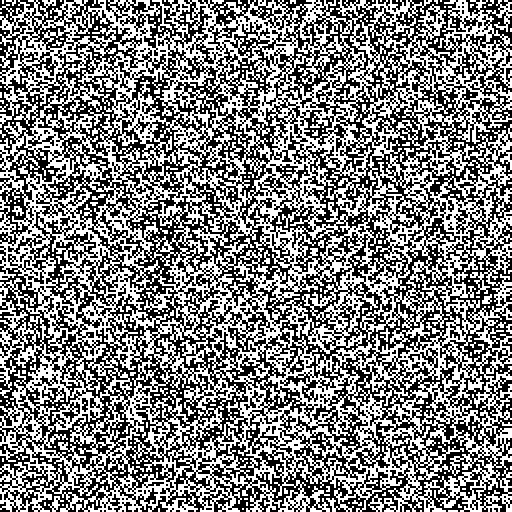

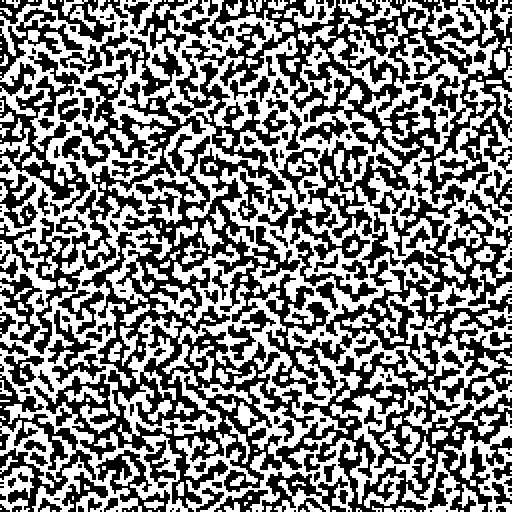

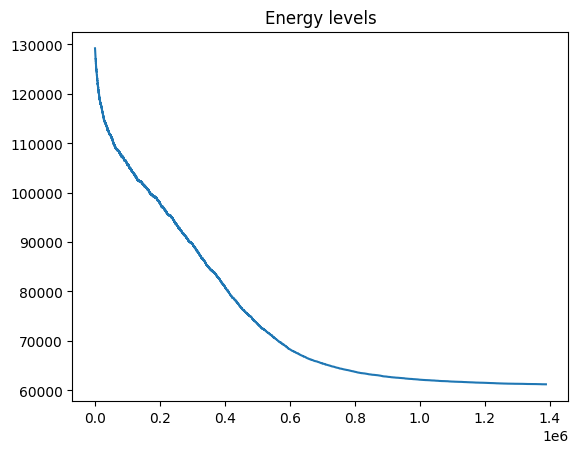

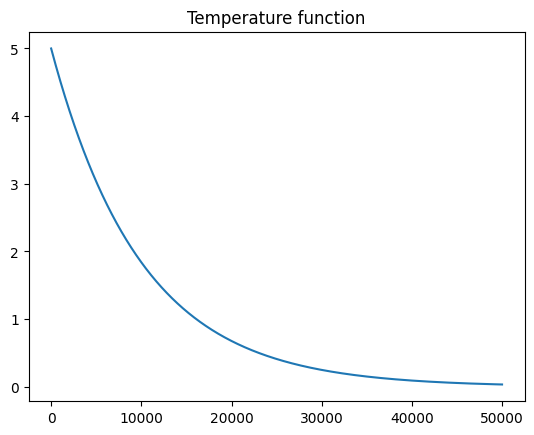

In [15]:
make_test(neighbor1, cell_energy1)

Wykres poziomów energii nie wskazuje, aby zachodził proces wyżarzania. Jednak zmiany energii przy przejściu ze stanu do stanu są to liczby zazwyczaj mniejsze niż 10, a początkowa energia układu wynosi około 130 tysięcy. Poniżej znajdują się wykresy, gdyby przeprowadzić ten sam program, ale w funkcji wyżarzania nie byłoby prawdopodobieństwa przeskoczenia do wyższego stanu energetycznego.

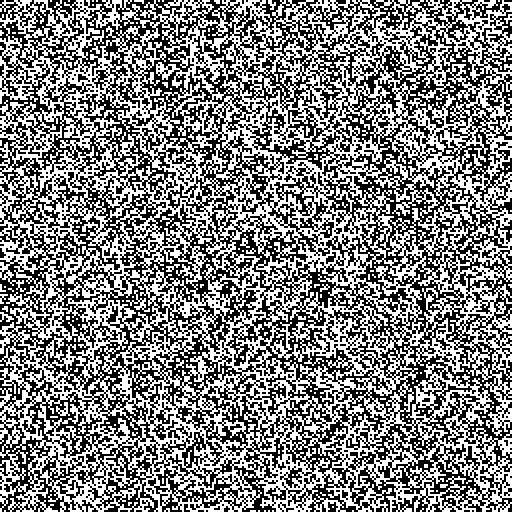

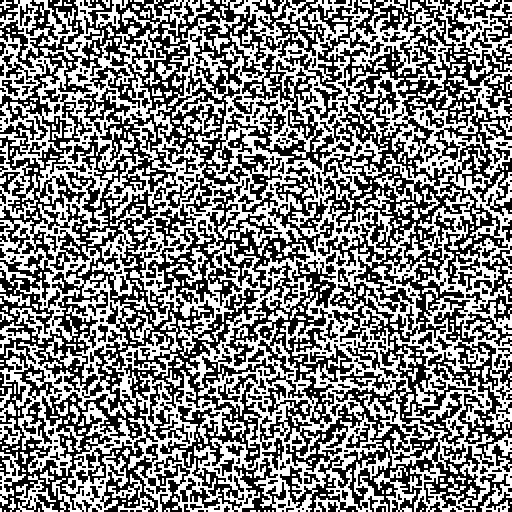

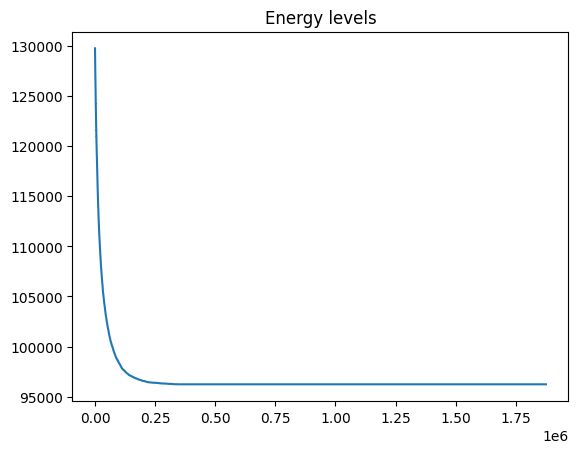

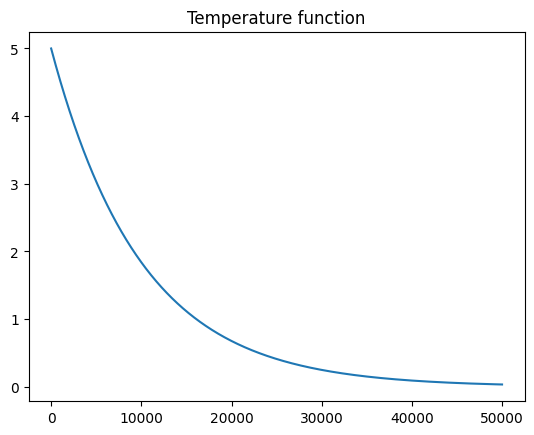

In [17]:
make_test(neighbor1, cell_energy1)

Widać, że proces już po pierwszych iteracjach utknął w minimum lokalnym, a osteteczna energia była prawie o 30 tysięcy większa niż przy wyżarzaniu.

#### Wizualizacja kolejnych kroków procesu

In [ ]:
frames = []
make_test(neighbor2, cell_energy5, save_gif=True)
frame_one = frames[0]
frame_one.save("annealing_gifs/binary1.gif", format="GIF", append_images=frames,
                   save_all=True, duration=100, loop=0)

<img src="annealing_gifs/binary1.gif" width="500" align="center">

#### Inny przykład wizualizacji

In [ ]:
frames = []
make_test(neighbor1, cell_energy6, dens=0.1, save_gif=True)
frame_one = frames[0]
frame_one.save("annealing_gifs/binary2.gif", format="GIF", append_images=frames,
                   save_all=True, duration=100, loop=0)

<img src="annealing_gifs/binary2.gif" width="500" align="center">

Przykłady wywołań dla kilku wybranych funkcji energii i funkcji generującej sąsiedztwo. Dla każdej pary (funkcja sąsiedztwa, funkcja energii) sprawdzam wywołanie dla 4 wyżej wymienionych gęstości. Te same obrazy znajdują się w folderze binary_pictures. Obrazy mają rozmiar 512 x 512, 256 odnosi sie do liczby komórek w macierzy, a każda komórka zajmuje 4 piksele.

In [170]:
tuples_to_test = [(neighbor1, cell_energy1), (neighbor1, cell_energy5), (neighbor1, cell_energy6), (neighbor1, cell_energy7), (neighbor2, cell_energy5),
                  (neighbor3, cell_energy4), (neighbor4, cell_energy2), (neighbor5, cell_energy7), (neighbor6, cell_energy4)]

descriptors = [(1, 1), (1, 5), (1, 6), (1, 7), (2, 5), (3, 4), (4, 2), (5, 7), (6, 4)]

In [165]:
def count_pixels(matrix, m):
    count1, count2 = 0, 0
    for i in range(m):
        for j in range(m):
            if matrix[i, j] == 0:
                count1 += 1
            elif matrix[i, j] == 1:
                count2 += 1
    return count1, count2

In [13]:
def make_tests():
    for dens in densities:
        m = 256
        matrix = np.zeros((m, m), dtype=int)
        prepare_image(matrix, m, dens)
        draw_image(matrix, filename=f"before_annealing_density_{int(dens*10)}_size{256}.png", popout=True)
        for (neighbor, cell_energy), (n, c) in zip(tuples_to_test, descriptors):
            f_name = f"after_neighbor_{n}_function_{c}_density_{int(dens*10)}_size_{256}.png"
            print(f_name)
            annealing(deepcopy(matrix), neighbor, cell_energy, filename=f_name)
            print()
            print()


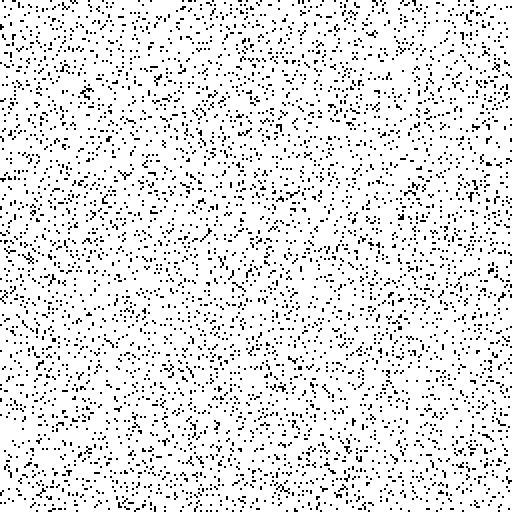

after_neighbor_1_function_1_density_1_size_256.png


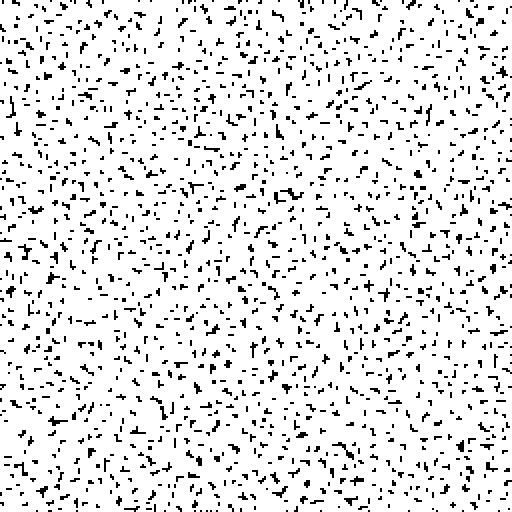



after_neighbor_1_function_5_density_1_size_256.png


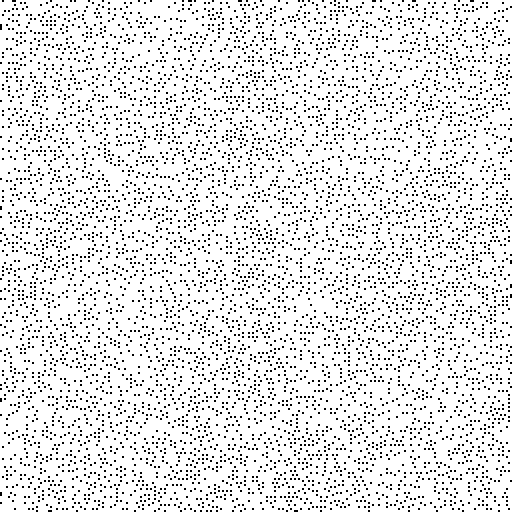



after_neighbor_1_function_6_density_1_size_256.png


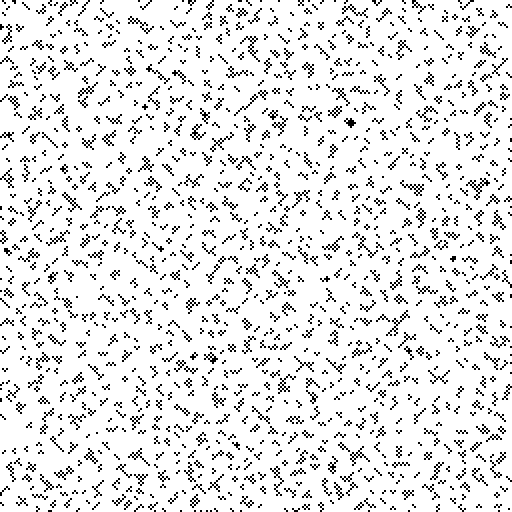



after_neighbor_1_function_7_density_1_size_256.png


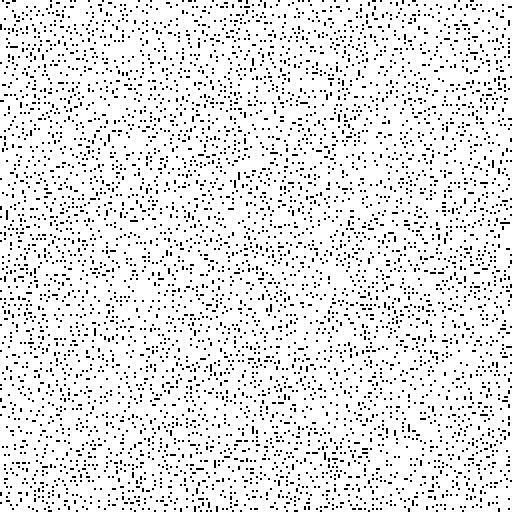



after_neighbor_2_function_5_density_1_size_256.png


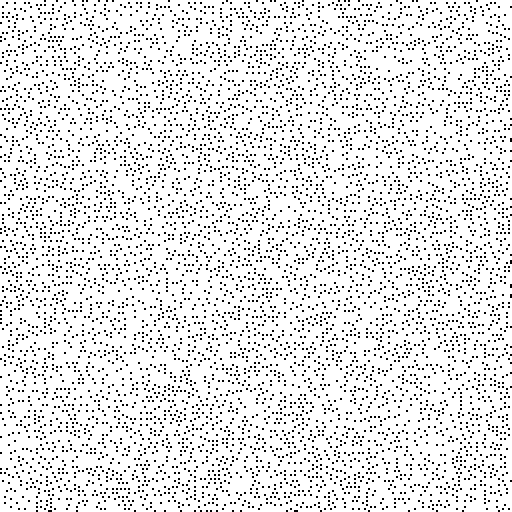



after_neighbor_3_function_4_density_1_size_256.png


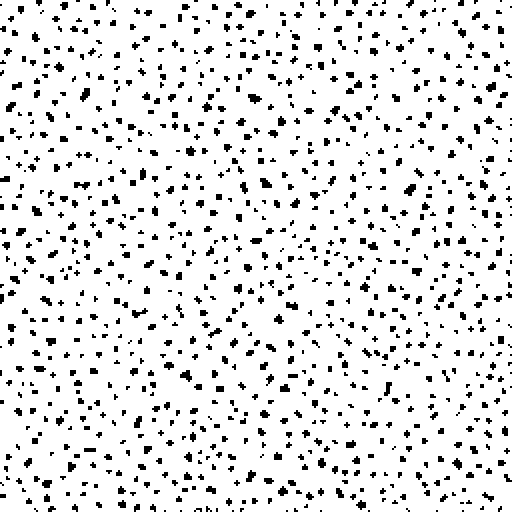



after_neighbor_4_function_2_density_1_size_256.png


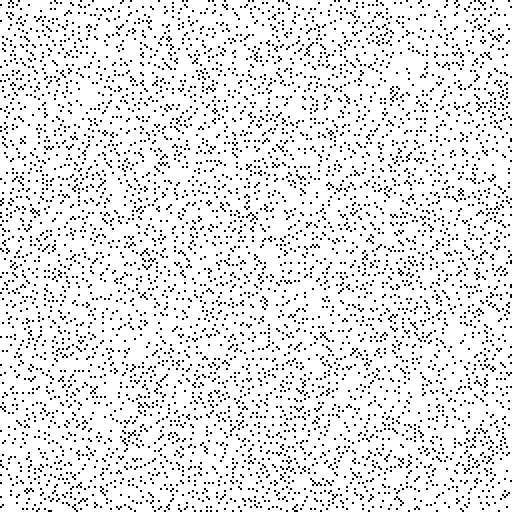



after_neighbor_5_function_7_density_1_size_256.png


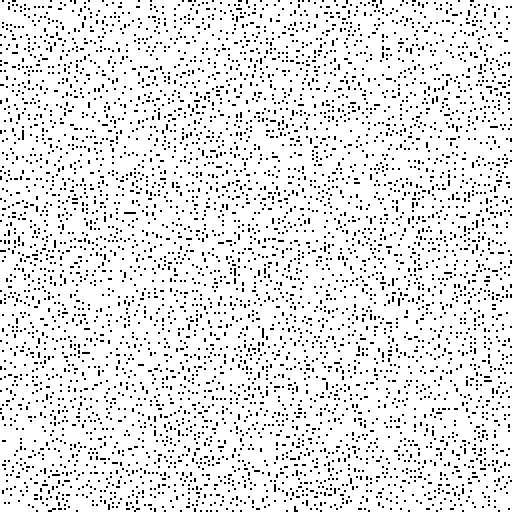



after_neighbor_6_function_4_density_1_size_256.png


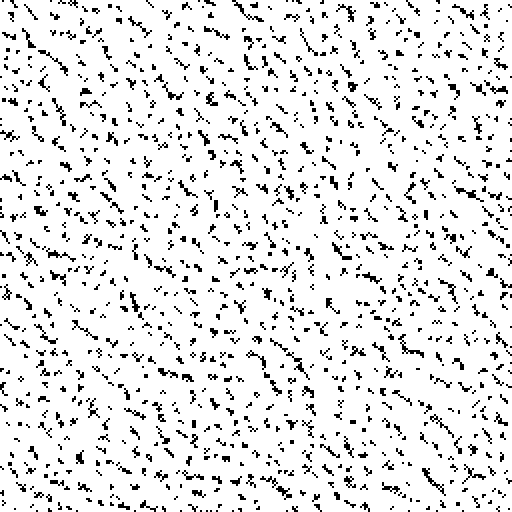

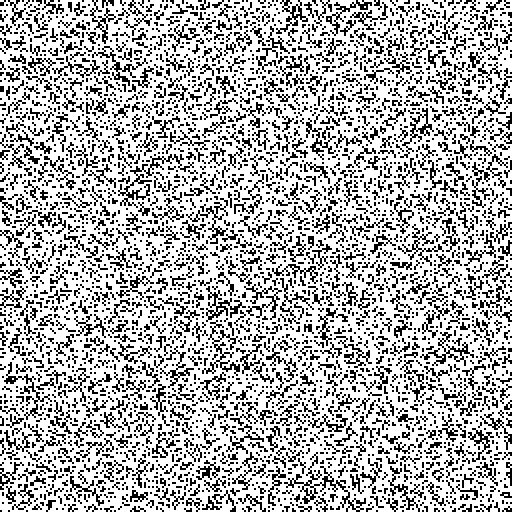

after_neighbor_1_function_1_density_3_size_256.png


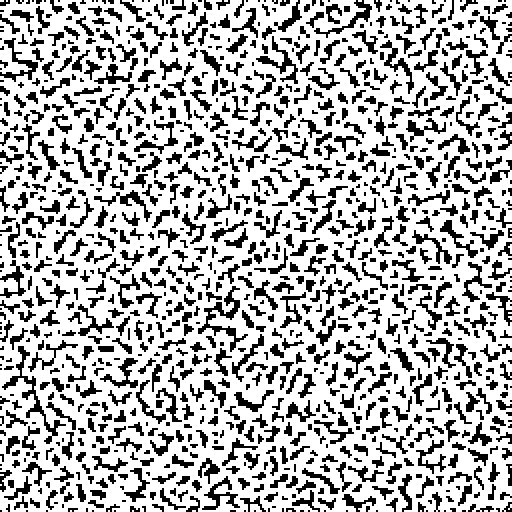



after_neighbor_1_function_5_density_3_size_256.png


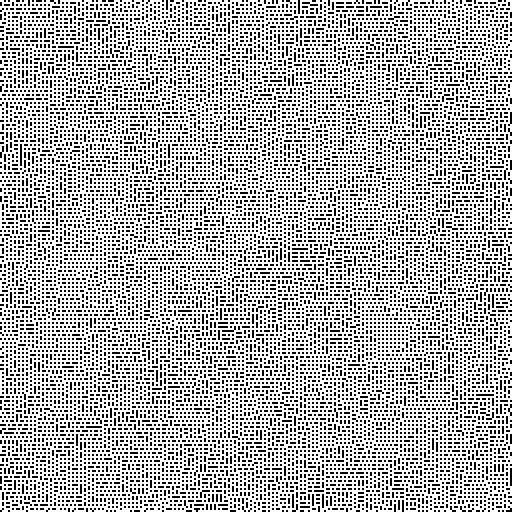



after_neighbor_1_function_6_density_3_size_256.png


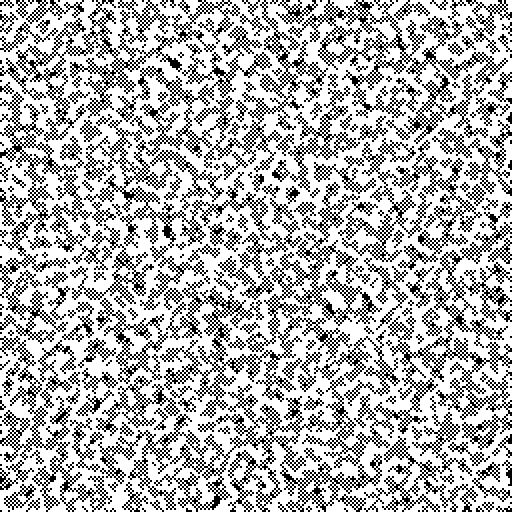



after_neighbor_1_function_7_density_3_size_256.png


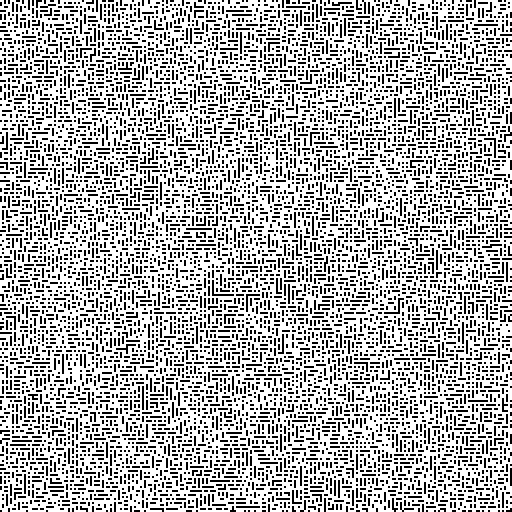



after_neighbor_2_function_5_density_3_size_256.png


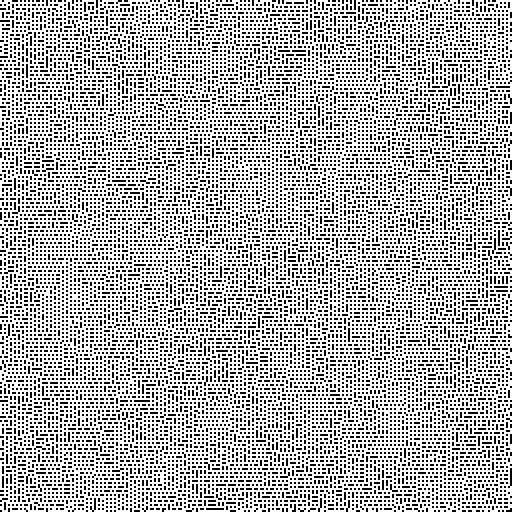



after_neighbor_3_function_4_density_3_size_256.png


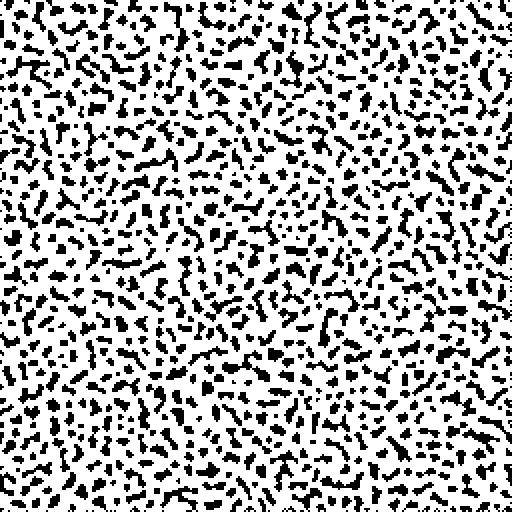



after_neighbor_4_function_2_density_3_size_256.png


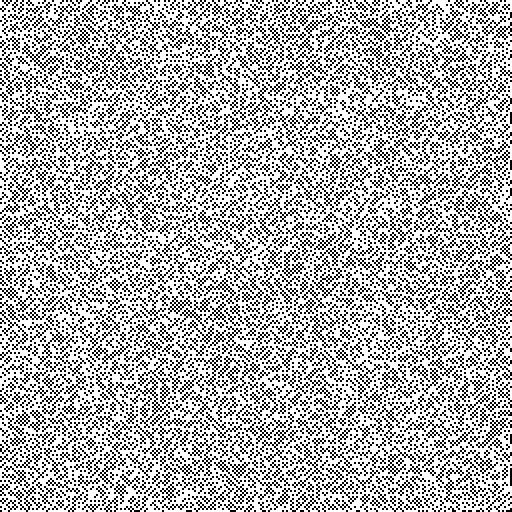



after_neighbor_5_function_7_density_3_size_256.png


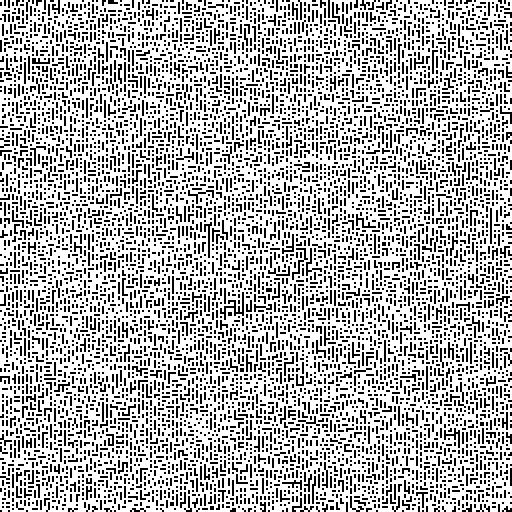



after_neighbor_6_function_4_density_3_size_256.png


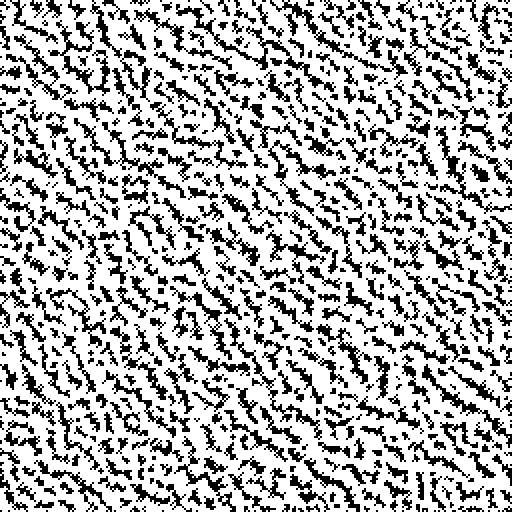

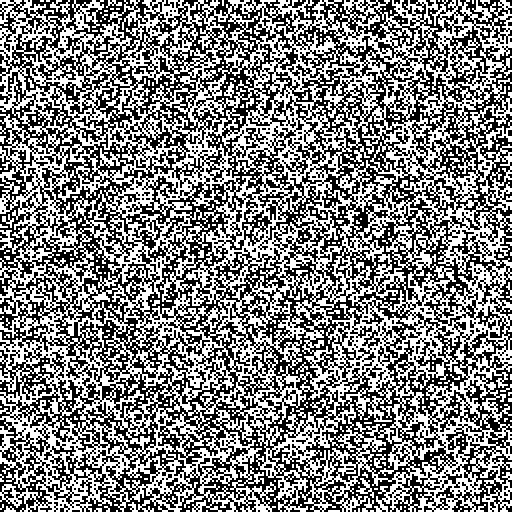

after_neighbor_1_function_1_density_5_size_256.png


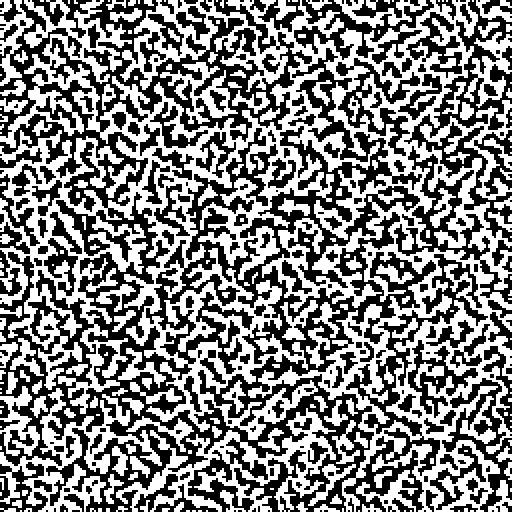



after_neighbor_1_function_5_density_5_size_256.png


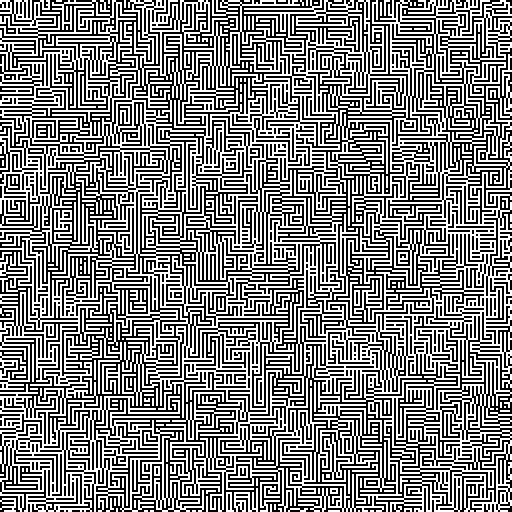



after_neighbor_1_function_6_density_5_size_256.png


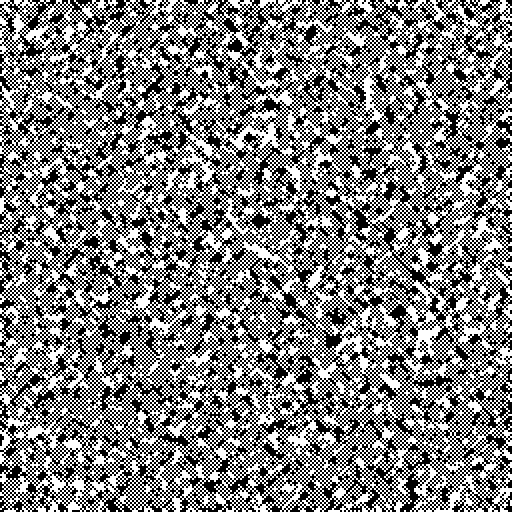



after_neighbor_1_function_7_density_5_size_256.png


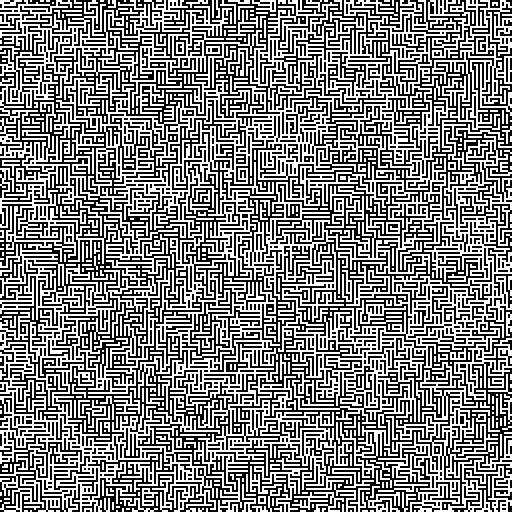



after_neighbor_2_function_5_density_5_size_256.png


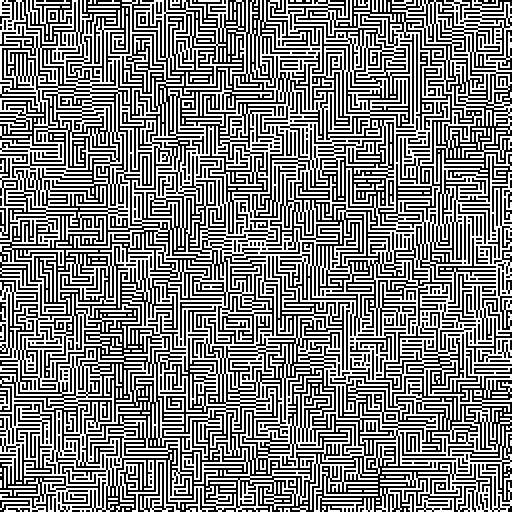



after_neighbor_3_function_4_density_5_size_256.png


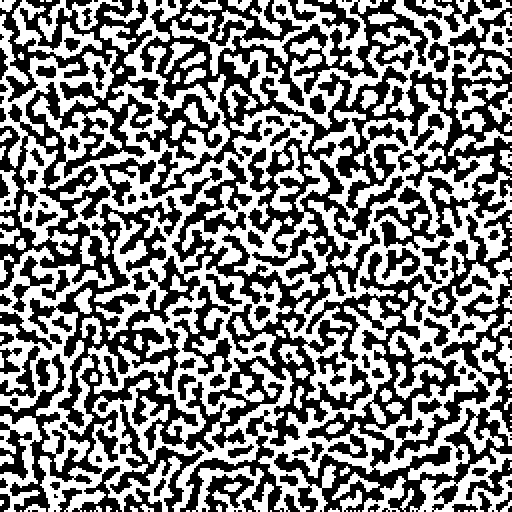



after_neighbor_4_function_2_density_5_size_256.png


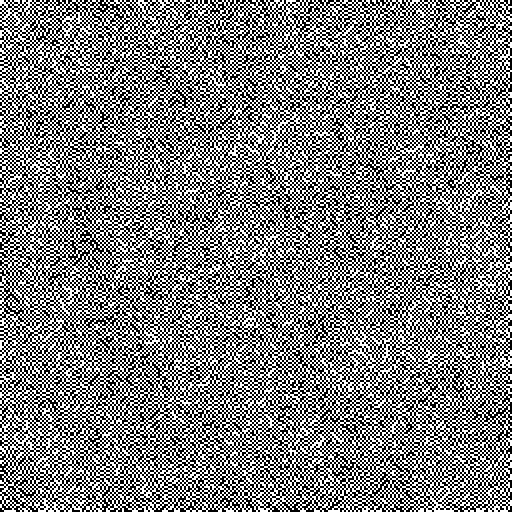



after_neighbor_5_function_7_density_5_size_256.png


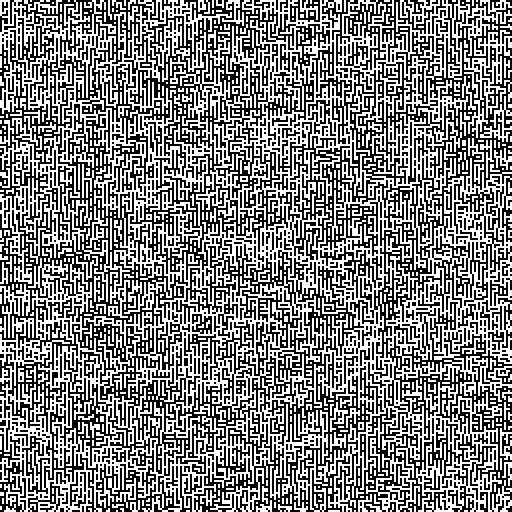



after_neighbor_6_function_4_density_5_size_256.png


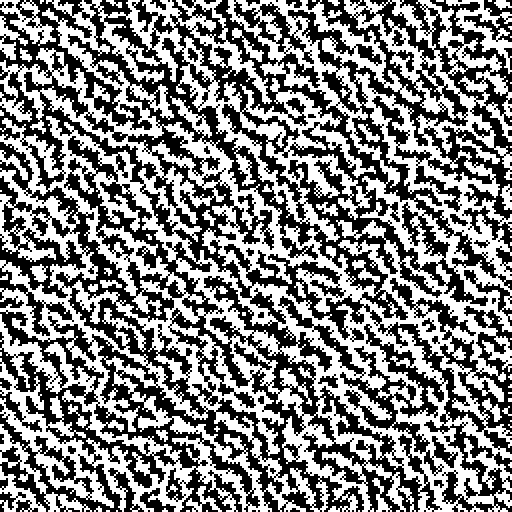

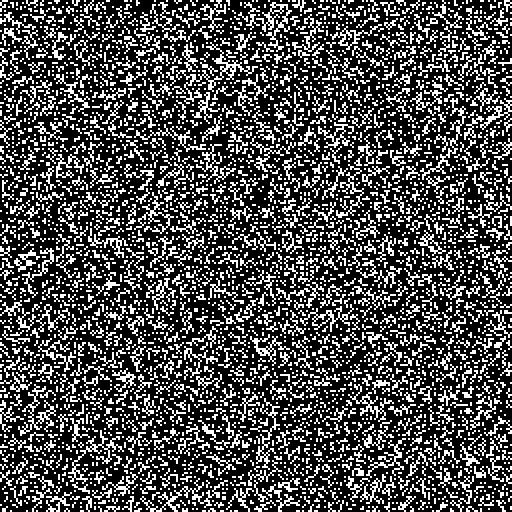

after_neighbor_1_function_1_density_7_size_256.png


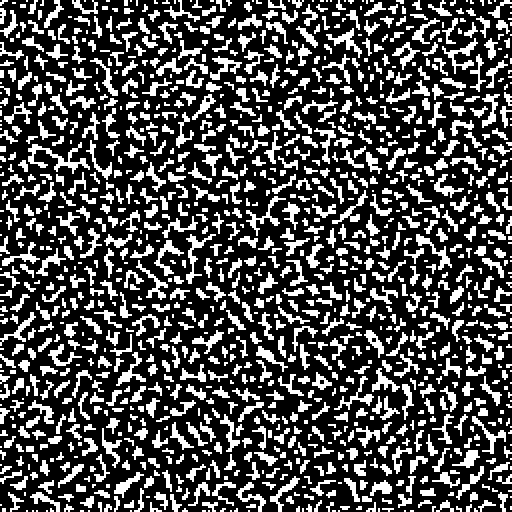



after_neighbor_1_function_5_density_7_size_256.png


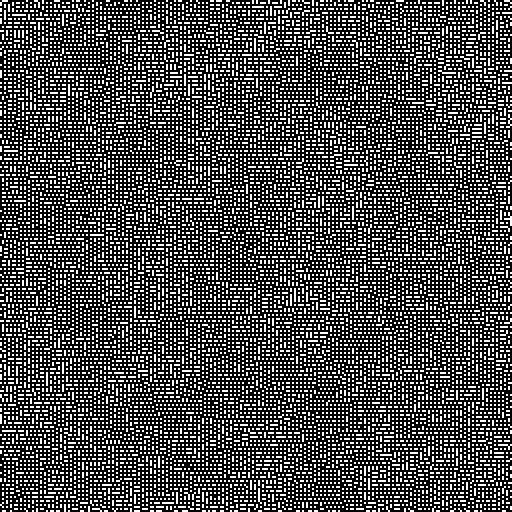



after_neighbor_1_function_6_density_7_size_256.png


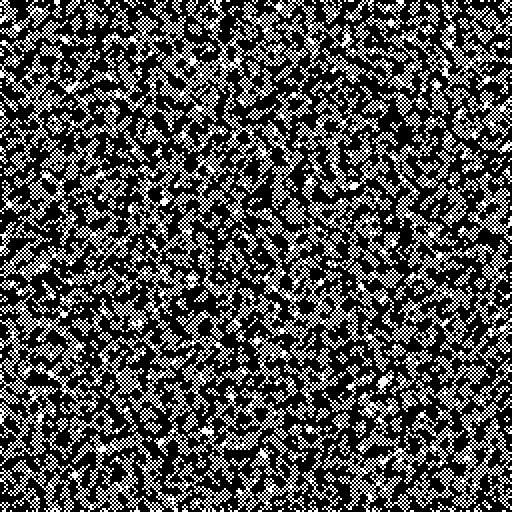



after_neighbor_1_function_7_density_7_size_256.png


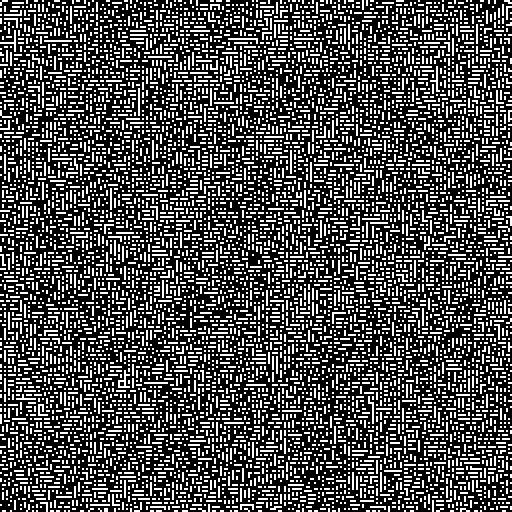



after_neighbor_2_function_5_density_7_size_256.png


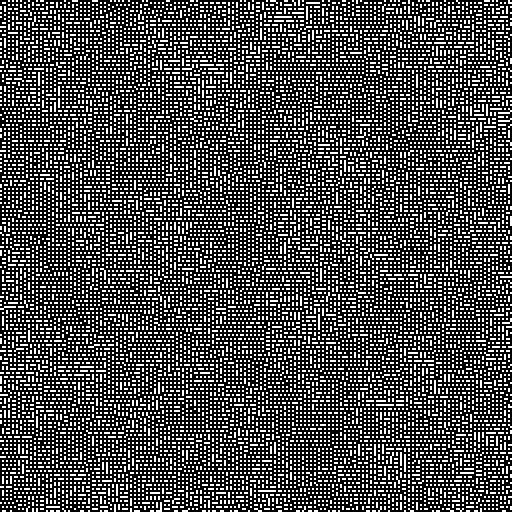



after_neighbor_3_function_4_density_7_size_256.png


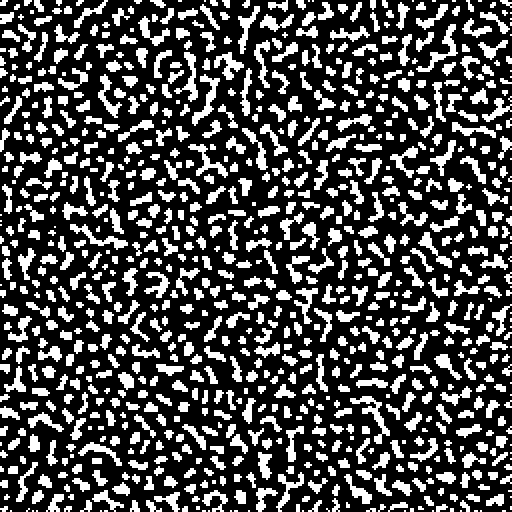



after_neighbor_4_function_2_density_7_size_256.png


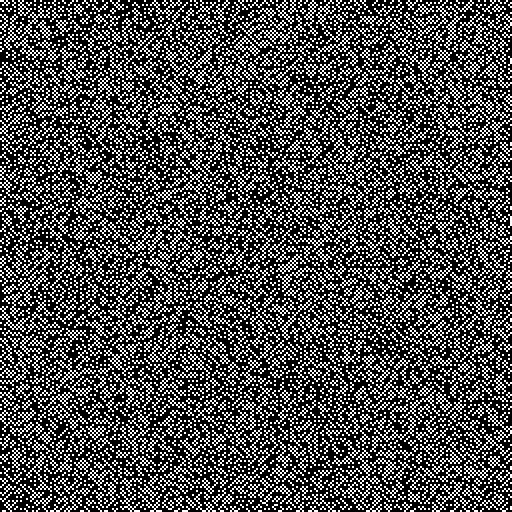



after_neighbor_5_function_7_density_7_size_256.png


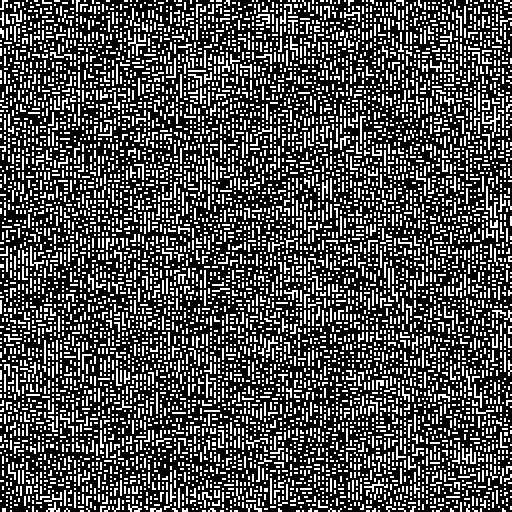



after_neighbor_6_function_4_density_7_size_256.png


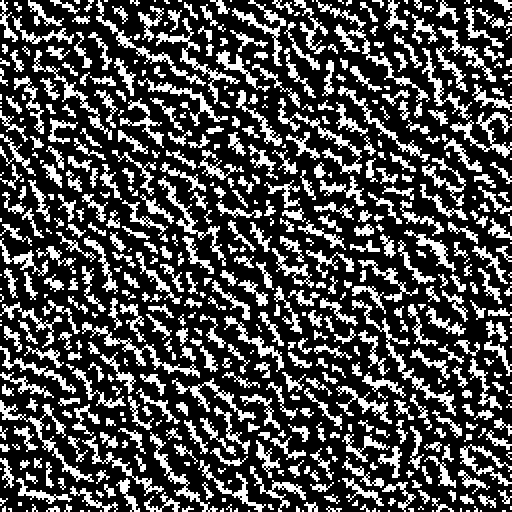

In [177]:
make_tests()